In [1]:
# 다운받은 API Token 업로드 하기
!pip install kaggle

from google.colab import files # → 이미 (만기되지 않은 Token이) 업로드 되어있다면 생략
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mongnyonglee","key":"1f9b2690a6d131428bb2bba9507233af"}'}

In [2]:
# json 파일 옮겨주기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle competitions download -c bike-sharing-demand

# 다운로드 된 것들 다 보기 
!ls

  0% 0.00/633k [00:00<?, ?B/s]
100% 633k/633k [00:00<00:00, 42.8MB/s]
  0% 0.00/140k [00:00<?, ?B/s]
100% 140k/140k [00:00<00:00, 45.0MB/s]
  0% 0.00/316k [00:00<?, ?B/s]
100% 316k/316k [00:00<00:00, 88.6MB/s]
kaggle.json  sample_data  sampleSubmission.csv	test.csv  train.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그려주기 위해 (colab환경에선 생략 가능)
%matplotlib inline

# font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# font_name = fm.FontProperties(fname=font_path, size=10).get_name()
# plt.rc('font', family=font_name, size=12)

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [5]:
train = pd.read_csv('train.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

In [7]:
test = pd.read_csv('test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

이번에는 feature로 사용할 변수들만 세분화 시키도록 하겠습니다.

In [8]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 16)

In [9]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 13)

In [ ]:
categorical_feature_names = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'month', 'year', 'hour']

for var in categorical_feature_names:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

원래는 범주형 데이터 같은 경우 One-hot encoding을 통해서 모델의 성능을 더 향상시킬 수 있는 게 일반적이긴 하나, 참고한 Notebook kernel에서는 큰 차이가 없었으므로 그냥 범주형 데이터로 취급하고 진행하기로 하였습니다.

In [11]:
feature_names = ['season', 'weather', 'temp', 'atemp', 'humidity',
                 'year', 'hour', 'dayofweek', 'holiday', 'workingday']
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [12]:
x_train = train[feature_names]

print(x_train.shape)
x_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [13]:
x_test = test[feature_names]

print(x_test.shape)
x_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [14]:
label_name = 'count'

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [16]:
# 모델 평가 함수 생성
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values)
        actual_values = np.exp(actual_values)

    # Numpy array(ndarray)형태로 변환
    predicted_values = np.array(predicted_values) # Calculate the exponential of all elements in the input array
    actual_values = np.array(actual_values)

    # 예측값과 실제값에 1을 더하고 로그를 씌워준다
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱해준다.
    diff = log_predict - log_actual
    diff = np.square(diff) # diff ** 2

    # 평균
    mean_diff = diff.mean()

    # 루트를 씌운다.
    score = np.sqrt(mean_diff)

    return score

## 선형 회귀 모델 Linear Regression Model
- 선형 회귀 또는 최소 제곱법은 가장 간단하고 오래된 회귀용 선형 알고리즘
- 선형 회귀는 예측과 train dataset에 있는 타겟 y 사이의 평균제곱오차(MSE)를 최소화하는 파라미터 w와 b를 찾는다.
- 매개변수가 없는 것이 장점이지만, 모델의 복잡도를 제어할 수 없다는 단점이 있다.
- 아래 [그래프](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%ED%9A%8C%EA%B7%80)에서 파란선이 선형회귀 모델을 나타내고 빨간 점들이 train data를 나타낸다

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Normdist_regression.png/450px-Normdist_regression.png)

In [47]:
RMSLE = {}

In [48]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', category=DeprecationWarning)

# 선형회귀 모델을 초기화 (객체 생성)
lModel = LinearRegression()

# 모델 학습
y_train_log = np.log1p(y_train)
lModel.fit(x_train, y_train_log)

# 예측 & 정확도 평가(검증)
pred = lModel.predict(x_train) # 자기자신 평가
print('RMSLE Value for Linear Regression: ',
      rmsle(np.exp(y_train_log), np.exp(pred), False))

RMSLE['Linear'] = rmsle(np.exp(y_train_log), np.exp(pred), False)

RMSLE Value for Linear Regression:  0.9803697923313522


> 내 생각: 왜 로그변환한 것의 1을 더한 값으로 학습을 시키지?

## 릿지 Regularization Model [Ridge]
- 회귀를 위한 선형 모델
- 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 feature가 주는 영향을 최소화(기울기를 작게 만듦)
- Regularization(규제)는 Overfitting(과대적합)이 되지 않도록 모델을 강제로 제한 한다는 의미
- max_iter(반복 실행하는 최대 횟수)는 3000을 넣어줌.

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803697902780834


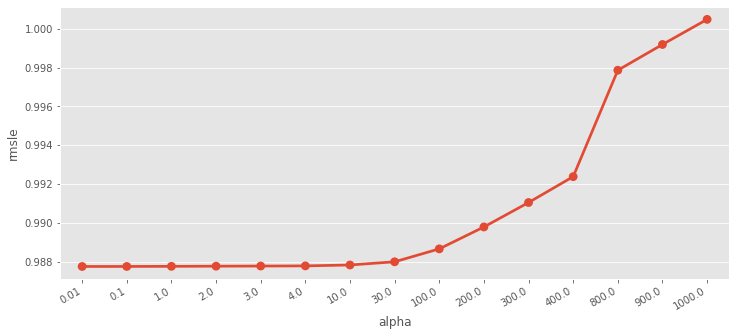

In [49]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
y_train_log = np.log1p(y_train)
grid_ridge_m.fit( x_train, y_train_log )
preds = grid_ridge_m.predict(x_train)
print(grid_ridge_m.best_params_)
print("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)

# df = pd.DataFrame(grid_ridge_m.grid_scores_)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"]) # parameters → params
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x) # mean_validation_score → mean_test_score

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

RMSLE['Ridge'] = rmsle(np.exp(y_train_log), np.exp(preds), False)

## 라쏘 Regularization Model [Lasso]
- 선형회귀의 Regularization(규제)를 적용하는 대안
- 계수를 0에 가깝게 만들려고 하며 이를 L1규제라고 하며, 어떤 계수는 0이 되기도 하는 데 이는 완전히 제외하는 feature가 생긴다는 의미다.
- feature 선택이 자동으로 이루어 진다고 볼 수 있다.
- alpha값의 기본 값은 1.0이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야 한다.
- GridSearch로 아래 Lasso 모델을 실행했을 때 best alpha 값은 0.0025
- max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9803727821457648


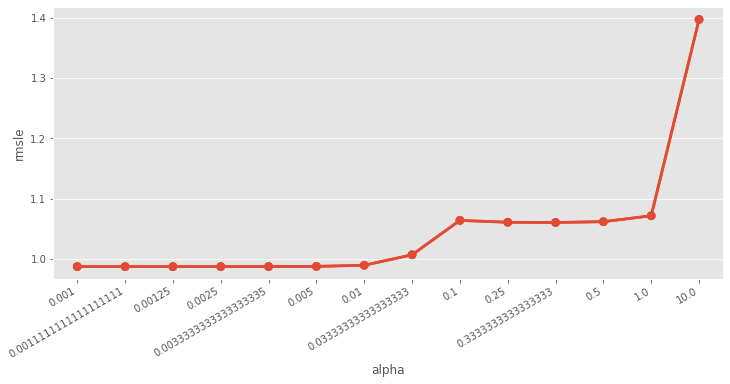

In [50]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( x_train, y_train_log )
preds = grid_lasso_m.predict(x_train)
print(grid_lasso_m.best_params_)
print("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

RMSLE['Lasso'] = rmsle(np.exp(y_train_log), np.exp(preds), False)

## Ensemble Models(앙상블 모델) - RandomForest

In [51]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
y_train_log = np.log1p(y_train)
rfModel.fit(x_train,y_train_log)
preds = rfModel.predict(x_train)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

RMSLE['RandomForest'] = rmsle(np.exp(y_train_log), np.exp(preds), False)

RMSLE Value For Random Forest:  0.10724749958038639


## Ensemble Models(앙상블 모델) - Gradient Boost
- 여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
- 회귀와 분류에 모두 사용할 수 있음
- 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
- 무작위성이 없고 강력한 사전 가지치기가 사용됨.
- 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
- learning_rate: 오차를 얼마나 강하게 보정할 것인지를 제어
- n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가되어 모델의 복잡도가 커지고 train dataset에서의 실수를 바로잡을 기회가 많아지지만, 너무 크면 모델이 복잡해지고 Overfitting(과대적합)이 될 수 있음.
- max_depth(max_leaf_nodes)복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.

In [52]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
y_train_log = np.log1p(y_train)
gbm.fit(x_train,y_train_log)
preds = gbm.predict(x_train)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

RMSLE['Gradient'] = rmsle(np.exp(y_train_log), np.exp(preds), False)

RMSLE Value For Gradient Boost:  0.2135740372724937


In [62]:
pd.DataFrame(list(RMSLE.items()),
                   columns=['method', 'score']).sort_values(by=['score'], axis=0)

# RMSLE

,method,score
3,RandomForest,0.107247
4,Gradient,0.213574
1,Ridge,0.980370
0,Linear,0.980370
2,Lasso,0.980373


RandomForest 모델이 가장 낮은 점수를 보여 이 모델을 이용하여 제출하겠습니다.

# Submit